# Project II :

## Conformal Based Classifier and Text Mining

The **%%capture** command supress the output of the cell. In this case it has the only purpose to keep the notebook clean. Delete it if needed.

In [1]:
%%capture  
!pip install gensim
!pip install nonconformist
from IPython.display import display, clear_output
import pandas as pd
import numpy as np
import random
import gensim
import matplotlib.pyplot as plt
from nonconformist.base import ClassifierAdapter
from nonconformist.nc import ClassifierNc
from nonconformist.icp import IcpClassifier
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.models import Model
import os.path
from os import path
import time

## Classifiers:

### Parameters:

The classifier needs a lot of parameters to generate the model and customize the predict method. 
It's posible to distinguish 4 groups of parameters: each group is characterized by the different context in which the parameters operate.

#### Global Parameters:

These parameters affect the classifier as a whole. They are also used in different combinations in order to test the system performance.

- *significance:* the initial significance for the conformal classifier.
- *significance_drop:* the quantity to subtract to the current significance in the case the conformal classifier returns the empty labelset.  
- *significance_plus:* the quantity to add to the current significance in the case the conformal classifier returns the full labelset. 
- *calibration:* represent the probability of an instance of the training-set to be used for calibration. If the value is 0 then no calibration is performed and the predict will return the prediction of the base classifier at the first step.   
- *optimization:* represent the probability of an instance of the training-set (after the removal of the calibrating set) to be used for local hyper-parameters optimization. If the value is 0 then the default values are used for the parameters and no optimization is performed.   

#### Word Embedding Parameters:

These parameters are linked to the gensim library which compute the word embedding. They are used to compute the embedding function necessary to transform tokens/words of an input instance in vectors of features.

- *embedding_size:* the size of the embedding space (how many features per word).
- *sg_true:* boolean parameter that allows to choose between skip-gram (=1) or CBOW (=0) as the algorithm to compute the word embedding.   
- *window_size:* number of neighbours tokens to be considered as part of a window in the training step of the embedding process.
- *min_count:* the number of the minimum occurrence for the tokens in order to be considered in the domain of the embedding function.

#### Preprocessing Parameters:

These parameters allow the customization of the preprocessing of an embedded text: every new instance must go through it in order to be processed by the predict function.  

- *remove_oov:* boolean value which determines if an 'out-of-vocabulary' token shall be excluded (=0) or not (=1) wrt the list of vectors of a given instance. Keeping such token means that it will be represented by a 0 vector.   
- *max_length:* the standard length of an instance in terms of tokens.   
- *padding_start:* if an embedded text has less tokens then *max_length* a 0-padding is necessary, this parameter determines if the padding will be applied before (=1) or after (=0) the given list of tokens. 
- *cut_head:* if an embedded text has more tokens then *max_length* some tokens must be cut-off, this parameters determines if the cut will be made at the beggining (=1) or at the end (=0) of the given list of tokens.   

#### CNN Parameters:

Parameters to customize the CNN and its convolutional keras layer. 

- *kernel_size:* height of the convolutional filters, the width is bounded by the number of features of each embedded token.  
- *filters:* number of filters to apply. 


In [2]:
GLOBAL_PARAMETERS = {
    'significance': 0.8,
    'significance_drop': 0.01,
    'significance_plus': 0.01,
    'calibration': 0.2,
    'optimization': 0.2,
                    }

WORD_EMBEDDING_PARAMETERS = {
    'embedding_size': [100],
    'sg_true': [0, 1],
    'window_size': [5],
    'min_count': [2]
}

PREPROCESSING_PARAMETERS = {
    'remove_oov': [0, 1],
    'max_length': [75, 110],
    'padding_start': [0],
    'cut_head': [0]
}

CNN_PARAMETERS = {
    'kernel_size': [3, 6],
    'filters': [32, 64],
}

# Uncomment this section for better optimization:
# WORD_EMBEDDING_PARAMETERS = {
#     'embedding_size': [100, 200],
#     'sg_true': [0, 1],
#     'window_size': [5, 7],
#     'min_count': [2, 1]
# }

# PREPROCESSING_PARAMETERS = {
#     'remove_oov': [0, 1],
#     'max_length': [75, 110],
#     'padding_start': [0, 1],
#     'cut_head': [0, 1]
# }

# CNN_PARAMETERS = {
#     'kernel_size': [3, 6],
#     'filters': [32, 64],
# }

### Conformal Classifier Adapter:

The **ConformalClassifierAdapter** class represent an interface required to work with the *nonconformist* libraries. To instantiate an object of this class the following parameters are required:  
    - *model:* the classifier model on top of which build the wrapper  
    - *fit_params:* additional parameters for *fit* method (default: None)  

#### Methods:

This wrapper class is necessary in order to instantiate a non-conformal classifier and it must implement the following methods.

> **fit(self, x, y):**

This function is supposed to start the training of the wrapped classifier.      

**Input:**   
    - *x:* list of instances of the training set   
    - *y:* list of labels in OHE format  
    
**Output:**   
    - *None*  

---

> **predict(self, x):**

This function compute the probability vectors of the input instances wrt the classes labels.      

**Input:**   
    - *x:* list of instances to classify  
    
**Output:**   
    - *prd:* list of proability-vectors 

In [3]:
class ConformalClassifierAdapter(ClassifierAdapter):
    def __init__(self, model, fit_params=None):
        super(ConformalClassifierAdapter, self).__init__(model, fit_params)
        
    def fit(self, x, y):
        self.model.fit(x, y, epochs=20, verbose=0)
    
    def predict(self, x):
        prd = self.model.predict(x)
        return prd 

### Worker Classifier:

The **WorkerClassifier** class contains the implementation of the sub-classifiers of the project.   
This object has a lot of fields in common with the **MasterClassifier** class: the only few differences are the absence of the *worker_classifiers* dictionary and the presence of the 'actual' parameters (necessary in the optimization steps) along with some other useful additional fields like *opt_loops*, *opt_counter* and *classes* used to keep track of the object state.   
In addition to that *instances*, *labels*, *training*, *optimization* and *calibration* fields must be pre-computed in order to initialize the classifier. 


#### Methods:

The class contains also the following methods.

---

> **compile_cnn(self, kernel, filters, embedding_size, max_length):**

This function compiles the CNN given the proper parameters.      

**Input:**   
    - *kernel:* height of the filters of the convolutional layer   
    - *filters:* number of filters   
    - *embedding_size:* width of the filters of the convolutional layer/number of features per token    
    - *max_length:* expected size of the instances in terms of tokens      
    
**Output:**   
    - *None*  

---

> **optimize(self):**

This function loop over the combinations of values of the 4 word-embedding parameters and computes, for each combination, the embedding function.      

**Input:**   
    - *None*         
    
**Output:**   
    - *None*  

 ---

> **optimize_preprocessing(self):**

This function loop over the combinations of values of the 4 preprocessing parameters and compute, for each combination, the embedded versions of the training and optimization set.      

**Input:**   
    - *None*         
    
**Output:**   
    - *None*  
    
---

> **optimize_cnn(self):**

This function loop over the combinations of values of the 2 convolutional parameters and compile, for each combination, the proper CNN model. This function also proceeds with the training and the evaluation phase of the neural network.        

**Input:**   
    - *None*         
    
**Output:**   
    - *None*  

---

> **accuracy_check(self, candidate_accuracy):**

This function update the current best parameters if the accuracy related to the last trained classifier is greater then the current best accuracy.      

**Input:**   
    - *candidate_accuracy:* accuracy of the classifier trained with the actual parameters combination.         
    
**Output:**   
    - *None*  
    
---

> **create_we(self, indexes, e_size, sg_true, w_size, m_count):**

This function generates the embedding function thanks to gensim library and its parameters.      

**Input:**   
    - *indexes:* indexes of the instances used to generate the embedding function   
    - *e_size:* the size of the embedding space (how many features per word)    
    - *sg_true:* boolean parameter that allows to choose between skip-gram (=1) or CBOW (=0) as the algorithm to compute the word embedding      
    - *w_size:* number of neighbours tokens to be considered as part of a window in the training step of the embedding process      
    - *m_count:* number of the minimum occurrence for tokens in order to be considered in the domain of the embedding function    
    
**Output:**   
    - *None*  

---

> **preprocess_raw_instance(self, single_instance, oov, pad, cut, m_length):**

This function process a single instance transforming it from a list of words to a numpy array of embedded tokens.      

**Input:**   
    - *single_instance:* list of word   
    - *oov:* boolean value which determines if an 'out-of-vocabulary' token shall be excluded (=0) or not (=1) wrt the list of vectors of a given instance. Keeping such token means that it will be represented by a 0 vector    
    - *pad:* if the instance has less words then max_length a 0-padding is necessary, this parameter determines if the padding will be applied before (=1) or after (=0) the given list of tokens    
    - *cut:*  if the instance has more words then max_length some tokens must be cut-off, this parameters determines if the cut will be made at the beggining (=1) or at the end (=0) of the given list of tokens  
    - *m_length:*  the standard length of an instance in terms of tokens   
    
**Output:**   
    - *r:* the preprocessed instance as numpy array  

---

> **predict_raw_instance(self, single_instance):**

This function has the aim to predict a set of candidate classes which represent the possible labels of the input instance. The function makes use of the global parameters to be sure that the predicted set is strictly smaller the the classifier's classes set. If the calibration list is empty this function will perform a standard prediction otherwise it will perform a conformal prediction.   

**Input:**   
    - *single_instance:* single instance to classify        
    
**Output:**   
    - *labels:* set of classes labels generated by the classifier or single label if *calibration* is empty 
    
---

> **train(self):**

This function perform the training of the worker classifier. This step includes: the optimization phase; the generation of the words embedding function; the preprocessing of the training and calibration set; the training of the classifier. Some of these phases could be skipped according to *global_params* internal values.  

**Input:**   
    - *None*         
    
**Output:**   
    - *None*

In [4]:
class WorkerClassifier:

    def __init__(self, 
                 instances,
                 labels,
                 training,
                 optimization,
                 calibration,
                 global_params = GLOBAL_PARAMETERS,
                 we_params = WORD_EMBEDDING_PARAMETERS,
                 pre_params = PREPROCESSING_PARAMETERS, 
                 cnn_params = CNN_PARAMETERS):
        
        self.instances = instances
        self.labels = labels
            
        self.training = training
        self.optimization =  optimization
        self.calibration = calibration
        
        self.global_params = global_params
        self.we_params = we_params
        self.pre_params = pre_params
        self.cnn_params = cnn_params
        
        self.best_we_params  = {
            'embedding_size': we_params['embedding_size'][0],
            'sg_true': we_params['sg_true'][0],
            'window_size': we_params['window_size'][0],
            'min_count': we_params['min_count'][0]
        }
        self.best_pre_params = {
            'remove_oov': pre_params['remove_oov'][0],
            'padding_start': pre_params['padding_start'][0],
            'cut_head': pre_params['cut_head'][0],
            'max_length': pre_params['max_length'][0]
        }
        self.best_cnn_params = {
            'kernel_size': cnn_params['kernel_size'][0],
            'filters': cnn_params['filters'][0]
        }
        
        #optimization loop variables
        self.best_accuracy = -1
        self.preprocessed_training = None
        self.preprocessed_optimization = None
        self.preprocessed_calibration = None
        
        self.current_embedding_size = None
        self.current_sg_true = None
        self.current_window_size = None
        self.current_min_count = None
        
        self.current_remove_oov = None
        self.current_padding_start = None
        self.current_cut_head = None
        self.current_max_length = None
        
        self.current_kernel_size = None
        self.current_filters = None        
                
        self.embeddings = None
        self.classifier = None
        self.nc_classifier = None
        
        self.opt_counter = 0
        self.opt_loops = len(we_params['embedding_size']) * len(we_params['sg_true']) * len(we_params['window_size']) * len(we_params['min_count'])\
                    * len(pre_params['remove_oov']) * len(pre_params['padding_start']) * len(pre_params['cut_head']) * len(pre_params['max_length'])\
                    * len(cnn_params['kernel_size']) * len(cnn_params['filters'])
        self.classes = self.labels[self.training].apply(lambda x: np.argmax(x)).unique()
        self.classes.sort()
        
    
    def train(self):
        
        print('\nTRAINING WORKER CLASSIFIER:\nlabels ->', self.classes)
        # optimization step
        if len(self.optimization) != 0:
            self.optimize()
            
        # word embedding
        print('Best accuracy: ', self.best_accuracy)
        print('Best parameters : \n', self.best_we_params,'\n',self.best_pre_params,'\n',self.best_cnn_params)     
        
        indexes = self.training + self.optimization
        self.create_we(indexes,
                       self.best_we_params['embedding_size'],
                       self.best_we_params['sg_true'],
                       self.best_we_params['window_size'],
                       self.best_we_params['min_count'])
        
        # preprocessing
        self.preprocessed_training = []
        for idx in indexes:
            preprocessed_instance = self.preprocess_raw_instance(self.instances[idx],
                                                                 self.best_pre_params['remove_oov'],
                                                                 self.best_pre_params['padding_start'],
                                                                 self.best_pre_params['cut_head'],
                                                                 self.best_pre_params['max_length'])
            self.preprocessed_training.append(preprocessed_instance)
        # NB: same field used in the optimization step but now wrt training+optimization sets
        self.preprocessed_training = np.stack(self.preprocessed_training)

        if len(self.calibration) != 0:
            self.preprocessed_calibration = []
            for idx in self.calibration:
                preprocessed_instance = self.preprocess_raw_instance(self.instances[idx],
                                                                     self.best_pre_params['remove_oov'],
                                                                     self.best_pre_params['padding_start'],
                                                                     self.best_pre_params['cut_head'],
                                                                     self.best_pre_params['max_length'])
                self.preprocessed_calibration.append(preprocessed_instance)
            self.preprocessed_calibration = np.stack(self.preprocessed_calibration)
        
        
        # CNN training
        self.compile_cnn(self.best_cnn_params['kernel_size'],
                         self.best_cnn_params['filters'],
                         self.best_we_params['embedding_size'],
                         self.best_pre_params['max_length'])
        
        tmp_tr = np.stack(np.take(self.labels, indexes).values)
        
        if len(self.calibration) != 0:
            tmp_clb = np.stack(np.take(self.labels, self.calibration).values)
            print("CONFORMAL TRAINING...")
            model = ConformalClassifierAdapter(self.classifier)
            nc = ClassifierNc(model)
            self.nc_classifier = IcpClassifier(nc)
            self.nc_classifier.fit(self.preprocessed_training, tmp_tr)
            self.nc_classifier.calibrate(self.preprocessed_calibration, np.array([np.where(r==1)[0][0] for r in tmp_clb]))
        else:
            print("STANDARD TRAINING...")
            self.classifier.fit(self.preprocessed_training, tmp_tr, epochs=20, verbose=0)
        
        print('DONE!\n\n')
        
        
        
    def compile_cnn(self, kernel, filters, embedding_size, max_length):
        
        loss_function = 'categorical_crossentropy'
        activation = 'softmax'
        classifications = len(self.labels[0])
        #print(classifications)
        i = Input(shape=(max_length, embedding_size))
        x = Conv1D(filters, kernel, activation='relu')(i)
        x = GlobalMaxPooling1D()(x)
        x = Dense(classifications, activation=activation)(x)
        self.classifier = Model(i,x)
        self.classifier.compile(loss=loss_function, optimizer='adam', metrics=['accuracy'])
        
        
    def optimize(self):
        
        self.opt_counter = 0
        for e_size in self.we_params["embedding_size"]:
            self.current_embedding_size = e_size
            for sg_true in self.we_params["sg_true"]:
                self.current_sg_true = sg_true
                for w_size in self.we_params["window_size"]:
                    self.current_window_size = w_size
                    for m_count in self.we_params["min_count"]:
                        self.current_min_count = m_count
                        
                        self.create_we(self.training, e_size, sg_true, w_size, m_count)
                        self.optimize_preprocessing()
                    
    
    def optimize_preprocessing(self):
    
        for oov in self.pre_params["remove_oov"]:
            self.current_remove_oov = oov
            for pad in self.pre_params["padding_start"]:
                self.current_padding_start = pad
                for cut in self.pre_params["cut_head"]:
                    self.current_cut_head = cut
                    for m_length in self.pre_params["max_length"]:
                        self.current_max_length = m_length 
                        
                        self.preprocessed_training = []
                        for idx in self.training:
                            preprocessed_instance = self.preprocess_raw_instance(self.instances[idx], oov, pad, cut, m_length)
                            self.preprocessed_training.append(preprocessed_instance)
                        self.preprocessed_training = np.stack(self.preprocessed_training)
                        
                        self.preprocessed_optimization = []    
                        for idx in self.optimization:
                            preprocessed_instance = self.preprocess_raw_instance(self.instances[idx], oov, pad, cut, m_length)
                            self.preprocessed_optimization.append(preprocessed_instance)
                        self.preprocessed_optimization = np.stack(self.preprocessed_optimization)
                                          
                        
                        self.optimize_cnn()
                        
                        
    def optimize_cnn(self):
        
        for k in self.cnn_params["kernel_size"]:
            self.current_kernel_size = k
            for f in self.cnn_params["filters"]:
                self.current_filters = f
                self.opt_counter = self.opt_counter + 1
                print("Tested Combinations: ", self.opt_counter, '/',self.opt_loops, end="\r")
                
                self.compile_cnn(k,f,self.current_embedding_size, self.current_max_length)
                tmp_tr = np.stack(np.take(self.labels, self.training).values)
                tmp_opt = np.stack(np.take(self.labels, self.optimization).values) 
                self.classifier.fit(self.preprocessed_training, tmp_tr, epochs=10, verbose=0)
                new_accuracy = self.classifier.evaluate(self.preprocessed_optimization,tmp_opt, verbose=0)[1] # accuracy is stored in the second cell
                
                self.accuracy_check(new_accuracy)
                
                
    
    def accuracy_check(self, candidate_accuracy):
        
        if self.best_accuracy < candidate_accuracy: 
            
            self.best_accuracy = candidate_accuracy
            
            self.best_we_params["embedding_size"] = self.current_embedding_size
            self.best_we_params["sg_true"] = self.current_sg_true
            self.best_we_params["window_size"] = self.current_window_size
            self.best_we_params["min_count"] = self.current_min_count
            
            self.best_pre_params["remove_oov"] = self.current_remove_oov
            self.best_pre_params["padding_start"] = self.current_padding_start
            self.best_pre_params["cut_head"] = self.current_cut_head
            self.best_pre_params["max_length"] = self.current_max_length
            
            self.best_cnn_params["kernel_size"] = self.current_kernel_size 
            self.best_cnn_params["filters"] = self.current_filters
            
            #print('\nNew best accuracy: ', self.best_accuracy)
            #print('\nNew best parameters : \n', self.best_we_params,'\n',self.best_pre_params,'\n',self.best_cnn_params,'\n')
            #print('\n')
    
    #preprocessing functions Training and Optimization
          
    
    def create_we(self, indexes, e_size, sg_true, w_size, m_count ):
        self.embeddings = gensim.models.Word2Vec(
            np.take(self.instances,indexes),
            window=w_size,
            size=e_size, 
            sg=sg_true, 
            min_count=m_count
        )
                
    
    #preprocessing instance (predict/train phase)
    
    def preprocess_raw_instance(self, single_instance, oov, pad, cut, m_length): 
        
        l = len(self.embeddings.wv[self.embeddings.wv.index2word[0]])
        r = []
        
        # embedding function application
        for tkn in single_instance:
            if tkn in self.embeddings.wv.index2word:
                r.append(self.embeddings.wv[tkn])
            else:
                if oov == 0:
                    r.append(np.zeros(l))
        
        lr = len(r)
        
        # padding
        if lr < m_length:
            tmp = [] 
            for i in range(0, m_length-lr):
                tmp.append(np.zeros(l))
            if pad == 0:
                r = tmp + r 
            else:
                r = r + tmp 
        #cut
        if lr > m_length:
            if cut == 0:
                r = r[0:m_length]
            else:
                r = r[lr-m_length:lr]
        
        return np.asarray(r)
    
    
    def predict_raw_instance(self, single_instance):
        
        labels = []
        si = []
        l = len(self.classes)
        tmp_sign = self.global_params['significance']
        si.append(self.preprocess_raw_instance(single_instance,
                                     self.best_pre_params['remove_oov'],
                                     self.best_pre_params['padding_start'],
                                     self.best_pre_params['cut_head'],
                                     self.best_pre_params['max_length']))
        si = np.stack(si)
        
        if len(self.calibration) == 0:
            labels.append(np.argmax(self.classifier.predict(si)))
        else:
            while len(labels) in [0, l] and len(labels) != 1:
                tmp = self.nc_classifier.predict(si, significance = tmp_sign)
                labels = [np.where(r==1)[0] for r in tmp][0].tolist()
                if len(labels) == l:
                    tmp_sign = tmp_sign + self.global_params['significance_plus']
                if len(labels) == 0:
                    tmp_sign = tmp_sign - self.global_params['significance_drop']
                    
        return labels
    

### Master Classifier:

The **MasterClassifier** class contains the implementation of the main classifier of the project.   
This object has several fields: some of them are hyperparameters of the classifier that are taken as input in the initialization phase. Their function is better explained in the proper section above.  
The other fields are listed in the following lines:   
    - *instances = None:* the list of the dataset instances that are used to generate the model     
    - *labels = None:* the list of class labels associated to each instance of the previous list     
    - *training = []:* the training-set instance indexes wrt the list instances      
    - *optimization = []:* the optimization-set instance indexes wrt the list instances     
    - *calibration = []:* the calibration-set instance indexes wrt the list instances    
    - *worker_classifiers = {}:* the dictionary of all the trained classifiers characterized by the different set of classes they recognize 
    
#### Methods:

The class contains also the following methods.

---

> **load_dataset(self, instances, labels):**

This function has the goal to load a dataset and split it according to the probability expressed by the global parameters proper of the classifier. The splitted datasets are stored in the *training*, *optimization*, and *calibration* fields of the classifier.      

**Input:**   
    - *instances:* instances of the dataset to load         
    - *labels:* labels of the classes related to the dataset's instances          
    
**Output:**   
    - *None*  

---

> **train(self):**

The train function simply start the training of the classifier calling the **train_worker** method on all the classes labels.      

**Input:**   
    - *None*           
    
**Output:**   
    - *None*   
    
---

> **train_worker(self, selected_labels):**

This function generate and train a worker classifier wrt the list of classes listed in *selected_labels*.    

**Input:**   
    - *selected_labels:* list of the encoded class labels to train on         
    
**Output:**   
    - *None*  
    
---

> **filter_dataset(self, indexes, selected_labels):**

This function has the aim to filter the input list of indexes keeping only the ones that are associated to an instance of the main dataset with label equal to one of the labels encoded in the *selected_labels* list.       

**Input:**   
    - *indexes:* list of indexes related to the main dataset        
    - *selected_labels:* list of valid labels: each different vector-label is represented by the index of his cell which contains '1'           
    
**Output:**   
    - *r:* filtered list of indexes  

---

> **predict_instance(self, instance):**

This function keeps triggering the predict method of the internal worker classifiers until one of these calls return a single label. The worker classifiers are chosen depending on the list of labels returned by the last called predict method: if the *classifiers* dictionary doesn't contain such classifier it's immediately generated. The procedure ensure the returning of a single value because of its loop and the property of down-closure of the predict method of the worker classifiers.     

**Input:**   
    - *instance:* the single instance to classify            
    
**Output:**   
    - *label[0]:* single label predicted 

---

> **predict(self, instances):**

This function tries to guess the correct class of a list of input instances returning, for each of them, a single label.       

**Input:**   
    - *istances:* either a pandas *Series* (of instances) or a single instance to classify           
    
**Output:**   
    - *labels:* the list of predicted labels with cardinality equal to the input parameter *instances* 

In [5]:
class MasterClassifier:
    
    def __init__(self, 
                 global_params=GLOBAL_PARAMETERS, 
                 we_params=WORD_EMBEDDING_PARAMETERS,
                 pre_params=PREPROCESSING_PARAMETERS, 
                 cnn_params=CNN_PARAMETERS):
        
        self.global_params = global_params
        self.we_params = we_params
        self.pre_params = pre_params
        self.cnn_params = cnn_params
            
        self.instances = None
        self.labels = None
            
        self.training = []
        self.optimization = []
        self.calibration = []
            
        self.worker_classifiers = {}
    
    
    def load_dataset(self, instances, labels):
            
        self.instances = instances
        self.labels = labels
        self.global_params['optimization']
            
        for i in range (0, len(self.instances)):
            if random.uniform(0,1) < self.global_params['calibration']:
                self.calibration.append(i)
            else: 
                if random.uniform(0,1) < self.global_params['optimization']:
                    self.optimization.append(i)
                else: 
                    self.training.append(i)
                            
                            
    def train(self):
        labels = [i for i in range(0,len(self.labels[0]))]
        print('\n\nTRAINING MASTER CLASSIFIER: \nglobal params ->', self.global_params, '\n')
        self.train_worker(labels)
    
    
    def train_worker(self, selected_labels):
            
        selected_labels.sort()
        self.worker_classifiers[str(selected_labels)] = WorkerClassifier(
                    self.instances,
                    self.labels,
                    self.filter_dataset(self.training, selected_labels),
                    self.filter_dataset(self.optimization, selected_labels),
                    self.filter_dataset(self.calibration, selected_labels),
                    self.global_params,
                    self.we_params,
                    self.pre_params,
                    self.cnn_params
                )
        self.worker_classifiers[str(selected_labels)].train()
    
    
    def filter_dataset(self, indexes, selected_labels):
        
        r = []
        for idx in indexes:
            if np.take(self.labels[idx], selected_labels).mean() > 0:
                r.append(idx)
        return r

    
    def predict_instance(self, instance):
        
        lbls = [i for i in range(0,len(self.labels[0]))]
        label = []
        
        while len(label) != 1:
            if str(lbls) in self.worker_classifiers:
                label = np.take(lbls, self.worker_classifiers[str(lbls)].predict_raw_instance(instance))
                label.sort()
                lbls = label 
            else:
                self.train_worker(lbls)
        
        return label[0]
    
    
    def predict(self, instances):
        
        labels = []
        if type(instances) == pd.core.series.Series:
            idx = 0
            for i in instances:
                idx += 1
                print('Tested Instances: ', idx, '/', len(instances), end="\r")
                labels.append(self.predict_instance(i))
        else:
            labels.append(self.predict_instance(instances))
        
        return labels
        
        

## Utils:

> **to_multiclass(idx, classes):**

This function encode the label of a class (originally expresed as a number) in a list of zeros except for the cell with index equal to the class label. Basically it's the application of the OHE on the class label values. This format is useful because it makes the computation of the softmax function  easier.      

**Input:**   
    - *idx:* current class id-number         
    - *classes:* number of different classes          
    
**Output:**   
    - *r:* list representing the encoded class label

In [6]:
def to_multiclass(idx, classes):
    r = np.zeros(classes)
    r[idx] =  1
    return r

> **chunks(lst, n):**

This yield successive n-sized chunks from a list.    

**Input:**   
    - *lst:* list         
    - *n:* size of a chunk             
    
**Output:**   
    - *lst[i:i + n]:* chunk of the original list 

In [7]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

## Dataset Prepocessing and Model Generation:

The original dataset of this project is represented by a list of textual obfuscated instances (one instance for each line in 'xtrain_obfuscated.txt') related to 12 different novels. The classes labels are expressed as integer in the range [0-11] and they are listed in the 'ytrain.txt' file.    
The following code loads the dataset and applies the OHE to the classes labels. Then the dataset is sampled to reduce the computational load according to the parameter *SAMPLE_SIZE*: the sampled dataset is also splitted in test and training set according to *TRAIN_SIZE*. The instances of the resulting dataset are splitted in list of tokens of length equal to the parameter *CHUNK_SIZE*.




In [12]:
ds_features = pd.read_csv("xtrain_obfuscated.txt", header=None, names=["text"])
ds_classes = pd.read_csv("ytrain.txt", header=None, names=["novel"])


# reset_index(drop=True): reset the index of the DataFrame 
ds = pd.concat([ds_features.reset_index(drop=True),ds_classes.reset_index(drop=True)], axis=1)
number_of_classes = len(set(ds.novel))
ds["novel"] = ds["novel"].apply(lambda value: to_multiclass(value,number_of_classes )) 


TRAIN_SIZE = 0.99
SAMPLE_SIZE = 0.5
CHUNK_SIZE = 4


ds["text"] = ds["text"].apply(lambda text:  [''.join(tokens) for tokens in chunks(list(text), CHUNK_SIZE)])
tmp = ds.sample(frac=SAMPLE_SIZE)
while tmp['novel'].apply(lambda x: np.argmax(x)).nunique() != 12:
    tmp = ds.sample(frac=SAMPLE_SIZE)
ds = tmp


if path.exists("train_smpl"+ str(SAMPLE_SIZE) +".csv") and path.exists("test_smpl"+ str(SAMPLE_SIZE) +".csv"):
    
    train = pd.read_csv('train_smpl'+ str(SAMPLE_SIZE) +'.csv')
    train['text'] = train['text'].apply(lambda x: x.replace("', '", " ")).apply(lambda x: x.replace("['", "")).apply(lambda x: x.replace("']", "")).apply(lambda x: x.split(" "))
    train['novel'] = train['novel'].apply(lambda x: x.replace(".,", "")).apply(lambda x: x.replace("[", "")).apply(lambda x: x.replace("]", "")).apply(lambda x: x.split(" ")).apply(lambda x: np.array(x).astype(np.float))

    test = pd.read_csv('test_smpl'+ str(SAMPLE_SIZE) +'.csv')
    test['text'] = test['text'].apply(lambda x: x.replace("', '", " ")).apply(lambda x: x.replace("['", "")).apply(lambda x: x.replace("']", "")).apply(lambda x: x.split(" "))
    test['novel'] = test['novel'].apply(lambda x: x.replace(".,", "")).apply(lambda x: x.replace("[", "")).apply(lambda x: x.replace("]", "")).apply(lambda x: x.split(" ")).apply(lambda x: np.array(x).astype(np.float))

else:    
    
    train = ds.sample(frac=TRAIN_SIZE, random_state=0)
    test = ds.drop(train.index)
    train = train.reset_index(drop=True)
    test = test.reset_index(drop=True)
    
    # to be sure that all classes will be considered
    while train['novel'].apply(lambda x: np.argmax(x)).nunique() != 12:
        train = ds.sample(frac=TRAIN_SIZE, random_state=0)
        test = ds.drop(train.index)
        train = train.reset_index(drop=True)
        test = test.reset_index(drop=True)
    
    train.to_csv(r'train_smpl'+ str(SAMPLE_SIZE) +'.csv', index = False, header=True)
    test.to_csv(r'test_smpl'+ str(SAMPLE_SIZE) +'.csv', index = False, header=True)


The following dictionary stores the list of values related to the different global parameters. Combination of these values will be used to generate and test different classifers.

In [13]:
gl_params = {
    'significance': [0.8, 0.4],
    'significance_drop': [0.01],
    'significance_plus': [0.01],
    'calibration': [0.0, 0.2],
    'optimization': [0.0, 0.2],
}

### Generation Step:

This cell contains the code which generates and tests each classifier. The test results will be stored in the proper DataFrame *results* along with the correct class-labels of the tested instances: the resulting object is saved at each iteration as a '.csv' file with name 'res.csv'. At the same time, the dictionary *classifiers* is filled with the new classifiers. 

In [14]:
glps = []
keys = []

if path.exists("res"+ str(SAMPLE_SIZE) +".csv"):
    results = pd.read_csv("res"+ str(SAMPLE_SIZE) +".csv")
    if len(results) != len(test):
        results = pd.DataFrame()
else:    
    results = pd.DataFrame()
    
results['ground_truth']=test['novel'].apply(lambda x: np.argmax(x))
classifiers = {}


In [11]:
for sig in gl_params['significance']:
    for sig_d in gl_params['significance_drop']:
        for sig_p in gl_params['significance_plus']:
            for cal in gl_params['calibration']:
                for opt in gl_params['optimization']:
                    glp = {}
                    glp['significance'] = sig
                    glp['significance_drop'] = sig_d
                    glp['significance_plus'] = sig_p
                    glp['calibration'] = cal
                    glp['optimization'] = opt
                    glps.append(glp)
                    keys.append(str([sig, sig_d, sig_p, cal, opt]))
    
for indx in range(len(list(results))-1, len(keys)):    
    
    mc = MasterClassifier(global_params=glps[indx])    
    classifiers[keys[indx]] = [mc]
    classifiers[keys[indx]][0].load_dataset(train['text'], train['novel'])
    classifiers[keys[indx]][0].train()
    
    print('TESTING MASTER CLASSIFIER: \nglobal params ->', glps[indx], '\n')
    results[keys[indx]] = classifiers[keys[indx]][0].predict(test['text'])
    print('\n--------------------------------------------------------------------------------------------\n')
    
    results.to_csv(r'res'+ str(SAMPLE_SIZE) +'.csv', index = False, header=True)
    
    



TRAINING MASTER CLASSIFIER: 
global params -> {'significance': 0.8, 'significance_drop': 0.01, 'significance_plus': 0.01, 'calibration': 0.0, 'optimization': 0.0} 


TRAINING WORKER CLASSIFIER:
labels -> [ 0  1  2  3  4  5  6  7  8  9 10 11]
Best accuracy:  -1
Best parameters : 
 {'embedding_size': 100, 'sg_true': 0, 'window_size': 5, 'min_count': 2} 
 {'remove_oov': 0, 'padding_start': 0, 'cut_head': 0, 'max_length': 75} 
 {'kernel_size': 3, 'filters': 32}
STANDARD TRAINING...
DONE!


TESTING MASTER CLASSIFIER: 
global params -> {'significance': 0.8, 'significance_drop': 0.01, 'significance_plus': 0.01, 'calibration': 0.0, 'optimization': 0.0} 

Tested Instances:  65 / 65
--------------------------------------------------------------------------------------------



TRAINING MASTER CLASSIFIER: 
global params -> {'significance': 0.8, 'significance_drop': 0.01, 'significance_plus': 0.01, 'calibration': 0.0, 'optimization': 0.2} 


TRAINING WORKER CLASSIFIER:
labels -> [ 0  1  2  3  4 

KeyboardInterrupt: 

In [31]:
# mc = MasterClassifier(global_params=glps[0])    
# classifiers[keys[0]] = [mc]
# classifiers[keys[0]][0].load_dataset(train['text'], train['novel'])
# classifiers[keys[0]][0].train()
#classifiers[keys[0]][0].predict(test['text'][0])

## Test Results:

The following table list, in each row, the labels predicetd by the classifiers. The first column contains the true labels of each test instance, the other columns contain the predicted label wrt a particular classifier.
Each classifier's name is represented by its specific global-parameters tuple.

In [15]:
results

,ground_truth,"[0.8, 0.01, 0.01, 0.0, 0.0]","[0.8, 0.01, 0.01, 0.0, 0.2]","[0.8, 0.01, 0.01, 0.2, 0.0]","[0.8, 0.01, 0.01, 0.2, 0.2]","[0.4, 0.01, 0.01, 0.0, 0.0]","[0.4, 0.01, 0.01, 0.0, 0.2]","[0.4, 0.01, 0.01, 0.2, 0.0]","[0.4, 0.01, 0.01, 0.2, 0.2]"
0,4,4,4,4,4,4,4,4,4
1,6,6,9,6,6,11,6,6,6
2,11,11,1,10,10,10,1,6,10
3,3,11,3,3,3,3,3,3,3
4,2,1,3,3,1,3,3,3,3
...,...,...,...,...,...,...,...,...,...
158,10,6,10,7,10,7,10,7,10
159,7,1,2,6,7,7,2,7,7
160,1,6,1,1,1,1,6,1,1
161,5,5,4,4,5,5,5,5,5


The following code has the goal to build the final DataFrame containing all the metrics of interest.

In [17]:
final_res = pd.DataFrame()
accuracy = pd.DataFrame()
confusion_matrix = []
col_sum = []
row_sum = []
c = 0


# accuracy utility computation
for name in list(results):
    if name != 'ground_truth':
        tmp = np.where(results['ground_truth'] == results[name], 1, 0)
        accuracy[name] = tmp
        confusion_matrix.append(np.zeros((12,12)))        

        
# confusion matrix computation
for name in list(accuracy):
    for ins in range(0,len(accuracy)):
        confusion_matrix[c][results['ground_truth'][ins]][results[name][ins]] += 1
    col_sum.append(confusion_matrix[c].sum(0))
    c=c+1
row_sum=confusion_matrix[0].sum(1)


# TPR & FPR computation
tpr = np.zeros((len(list(accuracy)),12))
fpr = np.zeros((len(list(accuracy)),12))

for cl in range(0, len(list(accuracy))):
    for lbl in range(0,12):
        if row_sum[lbl] != 0:       
            tpr[cl][lbl] = confusion_matrix[cl][lbl][lbl]/row_sum[lbl]
        if (row_sum.sum()-row_sum[lbl]) != 0:
            fpr[cl][lbl] = (col_sum[cl][lbl]-confusion_matrix[cl][lbl][lbl]) / (row_sum.sum()-row_sum[lbl])

            
final_res['classifier'] = list(accuracy)
#final_res['confusion_matrix'] = confusion_matrix
final_res['accuracy'] = accuracy.apply(lambda x: np.mean(x)).tolist()

lb = test['novel'].apply(lambda x: np.argmax(x)).unique()
lb.sort()

for idx in range(0,12):
    final_res['TPR'+str(idx)] = [row[idx] for row in tpr]
    final_res['FPR'+str(idx)] = [row[idx] for row in fpr]
    

In [18]:
final_res

,classifier,accuracy,TPR0,FPR0,TPR1,FPR1,TPR2,FPR2,TPR3,FPR3,...,TPR7,FPR7,TPR8,FPR8,TPR9,FPR9,TPR10,FPR10,TPR11,FPR11
0,"[0.8, 0.01, 0.01, 0.0, 0.0]",0.453988,0.0,0.000000,0.555556,0.096552,0.250,0.032258,0.421053,0.055556,...,0.470588,0.130137,0.631579,0.076389,0.00,0.006289,0.333333,0.041379,0.307692,0.020000
1,"[0.8, 0.01, 0.01, 0.0, 0.2]",0.705521,1.0,0.000000,0.777778,0.027586,0.500,0.012903,0.736842,0.076389,...,0.705882,0.068493,0.789474,0.027778,0.75,0.006289,0.555556,0.020690,0.769231,0.006667
2,"[0.8, 0.01, 0.01, 0.2, 0.0]",0.515337,0.0,0.006173,0.833333,0.096552,0.375,0.019355,0.578947,0.048611,...,0.705882,0.068493,0.526316,0.069444,0.00,0.006289,0.388889,0.020690,0.230769,0.006667
3,"[0.8, 0.01, 0.01, 0.2, 0.2]",0.662577,0.0,0.006173,0.777778,0.082759,0.375,0.006452,0.789474,0.041667,...,0.705882,0.068493,0.842105,0.041667,0.50,0.006289,0.722222,0.048276,0.461538,0.013333
4,"[0.4, 0.01, 0.01, 0.0, 0.0]",0.466258,1.0,0.012346,0.555556,0.075862,0.250,0.012903,0.473684,0.097222,...,0.647059,0.089041,0.473684,0.027778,0.25,0.000000,0.388889,0.075862,0.384615,0.040000
5,"[0.4, 0.01, 0.01, 0.0, 0.2]",0.674847,0.0,0.012346,0.777778,0.048276,0.250,0.019355,0.736842,0.062500,...,0.823529,0.041096,0.789474,0.048611,0.75,0.006289,0.611111,0.041379,0.615385,0.000000
6,"[0.4, 0.01, 0.01, 0.2, 0.0]",0.460123,0.0,0.000000,0.611111,0.131034,0.125,0.019355,0.421053,0.062500,...,0.705882,0.075342,0.631579,0.069444,0.00,0.000000,0.388889,0.055172,0.230769,0.013333
7,"[0.4, 0.01, 0.01, 0.2, 0.2]",0.711656,0.0,0.006173,0.777778,0.034483,0.500,0.025806,0.684211,0.041667,...,0.823529,0.061644,0.736842,0.034722,1.00,0.006289,0.722222,0.041379,0.615385,0.013333


The next cell will print the ROC-GRAPH specific to a particolar class label *roc_l*.

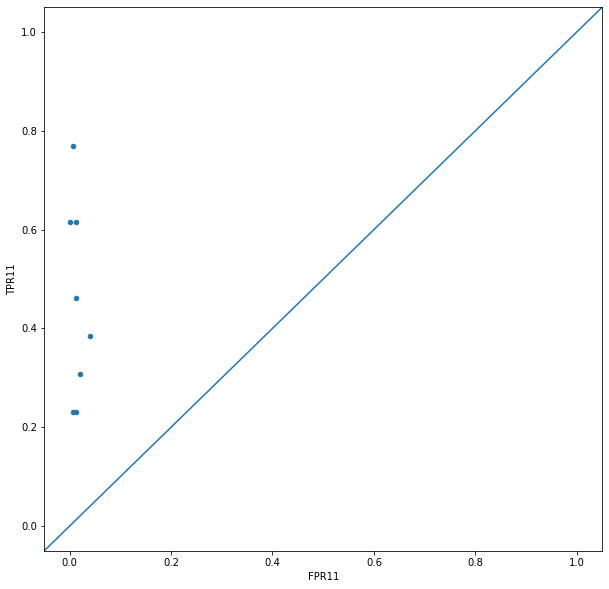

In [19]:
for roc_l in range(0,12):
    x = final_res.plot(x ='FPR'+str(roc_l), y='TPR'+str(roc_l), kind = 'scatter',figsize=(10,10))
    x.axline([0,0],[1,1])    
    plt.show()
    time.sleep(5)
    clear_output(wait=True)
    